In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_llm = pd.read_json("hf://datasets/Vezora/Tested-143k-Python-Alpaca/143k-Tested-Python-Alpaca-Vezora.json")
df_llm.head()

/mnt/F024B17C24B145FE/Repos/llmops-python-package/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,instruction,input,output
0,How can I add a function to find the maximum n...,,You can add the following function in your cod...
1,Devise a Python function that can detect and e...,,"Due to the complexity of the requirement, this..."
2,Please complete the modified coding challenge:...,,Here is a python solution for your coding chal...
3,You are given a code snippet that manipulates ...,,```python\nimport numpy as np\n\ndef modify_co...
4,You are tasked with implementing a job schedul...,,"```python\ndef schedule_jobs(partitions, job_s..."


In [2]:
df_input = df_llm.drop(columns=['input', 'output'])
df_input = df_input.rename(columns={'instruction': 'input'})

df_target = df_llm.drop(columns=['instruction'])
df_target = df_target.rename(columns={'output': 'response'})
df_target = df_target.rename(columns={'input': 'input_target'})

## EXPERIMENTS TO UNDERSTAND THE USE OF AUTOGEN:

* The experiment  is to find how to create a chat bot that can make complex task  with taskin capability, tooling  and code execution,  teh code excution capability it tis mainly to create code if it is not in the tooling  box.

* The principal source of data is https://github.com/microsoft/autogen and the available examples, with the help of the initial agent.
  
## Install AutoGen Studio for no-code GUI
pip install -U "autogenstudio"

## Autogen with litellm ( openai compatible)
 example of how to call a model using litellm, in this case it is called gimini-pro througth  the litellm gateway.

In [1]:
from autogen_core.models import UserMessage
from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(
    model="gemini-pro",
    base_url="http://localhost:4000/v1",
    api_key="sk-12345",
    model_info={
        "vision": True,
        "function_calling": True,
        "json_output": False,
        "family": "unknown",
    },
)

response = await model_client.create([UserMessage(content="What is the capital of France?", source="user")])
print(response)

finish_reason='stop' content='The capital of France is **Paris**.\n' usage=RequestUsage(prompt_tokens=7, completion_tokens=9) cached=False logprobs=None thought=None


/tmp/ipykernel_22530/1722096939.py:16: UserWarning: Resolved model mismatch: gemini-pro != gemini-2.0-flash. Model mapping in autogen_ext.models.openai may be incorrect.
  response = await model_client.create([UserMessage(content="What is the capital of France?", source="user")])


## Example of a autogen Agents


AutoGen AgentChat provides a set of preset Agents, each with variations in how an agent might respond to messages. All agents share the following attributes and methods:

name: The unique name of the agent.

description: The description of the agent in text.

on_messages(): Send the agent a sequence of ChatMessage get a Response. It is important to note that agents are expected to be stateful and this method is expected to be called with new messages, not the complete history.

on_messages_stream(): Same as on_messages() but returns an iterator of AgentEvent or ChatMessage followed by a Response as the last item.

on_reset(): Reset the agent to its initial state.

run() and run_stream(): convenience methods that call on_messages() and on_messages_stream() respectively but offer the same interface as Teams.

See autogen_agentchat.messages for more information on AgentChat message types.

https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/tutorial/agents.html



In [5]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [6]:
# Define a tool that searches the web for information.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gemini-pro",
    base_url="http://localhost:4000/v1",
    api_key="sk-12345",
    model_info={
        "vision": True,
        "function_calling": True,
        "json_output": False,
        "family": "unknown",
    },
)

agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

In [7]:
async def assistant_run() -> None:
    response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )
    print(response.inner_messages)
    print(response.chat_message)


# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=22, completion_tokens=6), content=[FunctionCall(id='call_432c0ca5-5350-4490-b93b-000cbd133873', arguments='{"query": "AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_432c0ca5-5350-4490-b93b-000cbd133873', is_error=False)], type='ToolCallExecutionEvent')]
source='assistant' models_usage=None content='AutoGen is a programming framework for building multi-agent applications.' type='ToolCallSummaryMessage'


/mnt/F024B17C24B145FE/Repos/llmops-python-package/.venv/lib/python3.12/site-packages/autogen_agentchat/agents/_assistant_agent.py:416: UserWarning: Resolved model mismatch: gemini-pro != gemini-2.0-flash. Model mapping in autogen_ext.models.openai may be incorrect.
  model_result = await self._model_client.create(
/mnt/F024B17C24B145FE/Repos/llmops-python-package/.venv/lib/python3.12/site-packages/autogen_agentchat/agents/_assistant_agent.py:416: UserWarning: Finish reason mismatch: stop != tool_calls when tool_calls are present. Finish reason may not be accurate. This may be due to the API used that is not returning the correct finish reason.
  model_result = await self._model_client.create(


## Multi-Modal Input


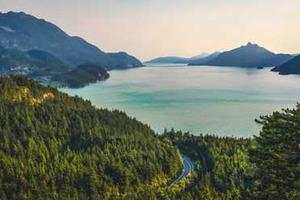

In [8]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img

In [9]:
# Use asyncio.run(...) when running in a script.
response = await agent.on_messages([multi_modal_message], CancellationToken())
print(response.chat_message.content)

The image shows a scenic view of a lake surrounded by mountains and forests. A road winds along the side of a forested hill in the foreground. The lake appears calm and reflects the sky, which seems to be at either sunrise or sunset given the soft lighting. The mountains in the background are hazy, adding depth to the landscape. The overall impression is one of natural beauty and tranquility.



## Streaming Messages

In [10]:
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.on_messages_stream(
    #     [TextMessage(content="Find information on AutoGen", source="user")],
    #     cancellation_token=CancellationToken(),
    # ):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.on_messages_stream(
            [TextMessage(content="Find information on AutoGen", source="user")],
            cancellation_token=CancellationToken(),
        ),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

---------- assistant ----------
[FunctionCall(id='call_3b007127-d6d6-4998-8631-185029ab315d', arguments='{"query": "AutoGen"}', name='web_search')]
[Prompt tokens: 395, Completion tokens: 7]
---------- assistant ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_3b007127-d6d6-4998-8631-185029ab315d', is_error=False)]
---------- assistant ----------
AutoGen is a programming framework for building multi-agent applications.
---------- Summary ----------
Number of inner messages: 2
Total prompt tokens: 395
Total completion tokens: 7
Duration: 1.06 seconds


/mnt/F024B17C24B145FE/Repos/llmops-python-package/.venv/lib/python3.12/site-packages/autogen_agentchat/agents/_assistant_agent.py:416: UserWarning: Both tool_calls and content are present in the message. This is unexpected. content will be ignored, tool_calls will be used.
  model_result = await self._model_client.create(


## Using Tools

install langchain 
``` bash
pip install langchain
```


In [14]:
import pandas as pd
from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_experimental.tools.python.tool import PythonAstREPLTool

df = pd.read_csv("https://raw.githubusercontent.com/pandas-dev/pandas/main/doc/data/titanic.csv")
df.head()
tool = LangChainToolAdapter(PythonAstREPLTool(locals={"df": df}))
# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gemini-pro",
    base_url="http://localhost:4000/v1",
    api_key="sk-12345",
    model_info={
        "vision": True,
        "function_calling": True,
        "json_output": False,
        "family": "unknown",
    },
)

agent = AssistantAgent(
    "assistant", tools=[tool], model_client=model_client, system_message="Use the `df` variable to access the dataset."
)
await Console(
    agent.on_messages_stream(
        [TextMessage(content="What's the average age of the passengers?", source="user")], CancellationToken()
    ),
    output_stats=True,
)

---------- assistant ----------
I don't have access to the passenger data including their ages. Is there a way to calculate this using the available tools?

[Prompt tokens: 75, Completion tokens: 27]
---------- Summary ----------
Number of inner messages: 0
Total prompt tokens: 75
Total completion tokens: 27
Duration: 0.79 seconds


/mnt/F024B17C24B145FE/Repos/llmops-python-package/.venv/lib/python3.12/site-packages/autogen_agentchat/agents/_assistant_agent.py:416: UserWarning: Resolved model mismatch: gemini-pro != gemini-2.0-flash. Model mapping in autogen_ext.models.openai may be incorrect.
  model_result = await self._model_client.create(


Response(chat_message=TextMessage(source='assistant', models_usage=RequestUsage(prompt_tokens=75, completion_tokens=27), content="I don't have access to the passenger data including their ages. Is there a way to calculate this using the available tools?\n", type='TextMessage'), inner_messages=[])